# LeNet Lab Solution
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [44]:
# Load pickled data
import pickle

training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']



assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples


## Generate Validation Set

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 3)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

5


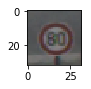

In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [47]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Augment data with noise and random rotations

Utility methods for random noise introduction into the image. This process introduces artificial translations
which may not have been captured in the training data. It ultimately helps train a network which is more robust to translations (rotation wise), but also other sources of noise. **Note that other types noise - in the sense of "types" of distributions - can also be introduced** (currently exploring geometrical features - based distributions)


In [48]:
import scipy.ndimage as ndi
from scipy.misc import imrotate


def transform_matrix_offset_center(matrix, x, y):
    ''' Taken from Keras implementation
        Incorporate to the transformation, the centering
        transformation of the image of size (x,y)
    :param matrix: transform matrix
    :param x: width of image
    :param y: height of image
    :return: transformation with respect to the center of image
    '''
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_axis=0, fill_mode='nearest', cval=0.):
    '''
        Apply transformation matrix to an image (x).
    :param x:
    :param transform_matrix:
    :param channel_axis:
    :param fill_mode:
    :param cval:
    :return:
    '''
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                                                         final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def rand_horiz_vert_shift(X, height_shift_range = 0.0, width_shift_range = 0.0):
    '''
        Perform random horizontal and vertical shifts of the image.
        Expect a 4-D array of format [sample][width][height][chanels]
    :param X: image list of shape ([sample], [width], [height], [chanels])
    :param height_shift_range: range of random shift as a % of image - y dir
    :param width_shift_range:  range of random shift as a % of image - x dir
    :return: Array of same size as X with shifted images
    '''

    # Image dimensions
    row_axis = 0
    col_axis = 1
    channel_axis = 2
    X_shift = np.zeros_like(X)

    for i in range(0, X.shape[0]):
        tx = np.random.uniform(-height_shift_range, height_shift_range) * X[0].shape[row_axis]
        ty = np.random.uniform(-width_shift_range, width_shift_range) * X[0].shape[col_axis]
        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        h, w = X[i].shape[row_axis], X[i].shape[col_axis]
        translation_matrix = transform_matrix_offset_center(translation_matrix, h, w)
        X_shift[i] = apply_transform(x = X[i], transform_matrix = translation_matrix,
                                     channel_axis = channel_axis,
                                     fill_mode='constant', cval=0.)

    return X_shift

def rand_shear_shift(X, shear_range = 0.0):
    '''
        Apply random shear (rotation in degrees) transformation to list of images
    :param X: Image list of shape ([sample], [width], [height], [chanels])
    :param shear_range: range of sheer in degrees
    :return: shear rotated image list of same size as input
    '''

    row_axis = 0
    col_axis = 1
    channel_axis = 2

    range_rad = np.pi / 180 * shear_range

    X_shear = np.zeros_like(X)

    for i in range(0, X.shape[0]):
        shear = np.random.uniform(-range_rad, range_rad)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        h, w = X[i].shape[row_axis], X[i].shape[col_axis]
        translation_matrix = transform_matrix_offset_center(shear_matrix, h, w)
        X_shear[i] = apply_transform(x=X[i], transform_matrix=translation_matrix,
                                     channel_axis=channel_axis,
                                     fill_mode='nearest', cval=0.)
    return X_shear

def rand_rotations(X, rotation_range):
    # Iterate through the list of images and rotate
    # X : numpy array with shape [samples][w][h][channels]
    # rotation_range: angle (in degrees) range from which to uniformly randomly sample

    X_rot = np.zeros_like(X)
    for i in range(0, X.shape[0]):
        theta = np.random.uniform(-rotation_range, rotation_range)
        X_rot[i] = imrotate(X[i], theta)

    return X_rot

def standardize_images(X):
    '''
     Standardize image pixel values for each of its channels
     by subtracting the mean for each channel
    :param X: array of images with shape : ([samples],[w],[h],[channels])
    :return:
    '''
    channel_axis = 2
    X_norm = np.zeros(shape=X.shape, dtype='float32')
    for i in range(0, X.shape[0]):
        im = X[i].astype(dtype = 'float32')
        im -= np.mean(im, axis=channel_axis, keepdims=True)
        # im /= (np.std(im, axis=channel_axis, keepdims=True) + 1e-7)
        X_norm[i] = im

    return X_norm


### Plots of several rotations

Examples of image transforms

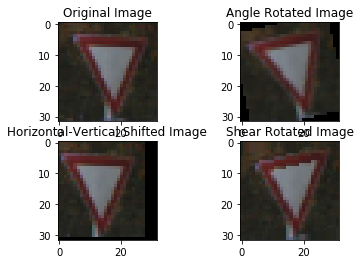

In [6]:
index = random.randint(0, len(X_train))

im = X_train[index].reshape((1,) + X_train[index].shape)
plt.subplot(220 + 1 + 0)
plt.imshow(im.squeeze())
plt.title('Original Image')

plt.subplot(220 + 1 + 1)
plt.imshow(rand_rotations(im, 50).squeeze())
plt.title('Angle Rotated Image')

plt.subplot(220 + 1 + 2)
plt.imshow(rand_horiz_vert_shift(im, 0.3, 0.3).squeeze())
plt.title('Horizontal-Vertical Shifted Image')

plt.subplot(220 + 1 + 3)
plt.imshow(rand_shear_shift(im, 40).squeeze())
plt.title('Shear Rotated Image')


## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

*Here several batch sizes were tried*. One limitation is memory of GPU.

In [49]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 150 # Effects processing speed and memory use of GPU
tf.reset_default_graph()

## Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # GT: Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob = keep_prob)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # GT: Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob = keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    
    Wout = tf.concat(values=[tf.reshape(conv1_W, shape=(1, -1)),
                             tf.reshape(conv2_W, shape=(1, -1)),
                             tf.reshape(fc1_W, shape=(1, -1)),
                             tf.reshape(fc2_W, shape=(1, -1)),
                             tf.reshape(fc3_W, shape=(1, -1))],
                     concat_dim=1)
    
    return logits, Wout

## Features and Labels
Train LeNet to classify German traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline : LeNet
Create a training pipeline that uses the model to classify German traffic data.

*Applying decaying learning rate*

![LearningRate](LearningRate.jpg)

In [10]:
# rate = 0.001

# decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

decay_step = 40
global_step = tf.placeholder(tf.float32) # Use the number of epochs

rate = tf.train.exponential_decay(learning_rate = 0.001, 
                                  decay_rate = 0.99, 
                                  global_step = global_step,
                                  decay_steps = decay_step, # Decay every these many steps
                                  staircase=True)

logits, Wout = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=one_hot_y)

# Loss function: Cross Entropy +  L2 regularization cost
loss_operation = tf.reduce_mean(cross_entropy + 0.01*tf.nn.l2_loss(Wout))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the *loss* and *accuracy* of the model for a given dataset.

**IMPORTANT: Keep probability must be set to 1.0 for the dropout layers during evaluation !!** We don't want to drop neurons during testing.

In [11]:
import sklearn.metrics as metrics

# Operation for obtaining the class decision, which is based on the largest logit score (value)
pred_op = tf.argmax(logits, 1)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.
    total_loss = 0.

    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]


        y_pred = sess.run(pred_op, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})

        # y_true = np.argmax(batch_y, 1)
        y_true = batch_y
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, average='macro')
        recall = metrics.recall_score(y_true, y_pred, average='macro')
        f1 = metrics.f1_score(y_true, y_pred, average='macro')

        # Measures on the batch
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
        total_precision +=(precision * len(batch_x))
        total_recall +=(recall * len(batch_x))
        total_f1 +=(f1 * len(batch_x))

    return total_accuracy / num_examples, \
           total_loss / num_examples, \
           total_precision / num_examples, \
           total_recall / num_examples, \
           total_f1 / num_examples

## Train LeNet Model
Run the training data through the training pipeline to train the model.

1 - Before each epoch, shuffle the training set.

2 - Augment batch data: translations, shifts, shear

3 - Decay learning rate every `decay_step` epochs

After each epoch, measure the loss and accuracy of the validation set

Save the model after training.


In [12]:
saver = tf.train.Saver()

# Noise parameters (random translations of the image)
angle_rot_range_deg = 10
angle_shear_range_deg = 4
shift_portion = 0.3

# Keep probability for dropout layer
keep_prob_val = 0.7
bestF1Score = 0.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    step_divide = float(BATCH_SIZE);
    
    print("Training...")
    print()

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        if (i % decay_step) == 0:
            step_divide = float(i*BATCH_SIZE)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            # Introduce random noise (translations: rotations, shifts, etc)
            batch_x = rand_rotations(batch_x, angle_rot_range_deg)
            batch_x = rand_horiz_vert_shift(batch_x, shift_portion, shift_portion)
            batch_x = rand_shear_shift(batch_x, angle_shear_range_deg)
            
            # Run session
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y, 
                                                    keep_prob:keep_prob_val,
                                                    global_step: step_divide})
        
        
        validation_accuracy, validation_loss, validation_precision, validation_recall, validation_F1 = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print("Validation Precision = {:.3f}".format(validation_accuracy))
        print("Validation Recall = {:.3f}".format(validation_recall))
        print("Validation F1 = {:.3f}".format(validation_F1))
        print("----------------------------------")
        
        if bestF1Score < validation_F1:
            bestF1Score = validation_F1
            print('Validation F1 score improved.. saving model')
            saver.save(sess, './lenet')
            print("----------------------------------")

Training...



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average,

EPOCH 1 ...
Validation Accuracy = 0.083
Validation Loss = 5.305
Validation Precision = 0.083
Validation Recall = 0.043
Validation F1 = 0.022
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 2 ...
Validation Accuracy = 0.133
Validation Loss = 4.642
Validation Precision = 0.133
Validation Recall = 0.074
Validation F1 = 0.043
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 3 ...
Validation Accuracy = 0.159
Validation Loss = 4.243
Validation Precision = 0.159
Validation Recall = 0.088
Validation F1 = 0.057
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 4 ...
Validation Accuracy = 0.202
Validation Loss = 3.856
Validation Precision = 0.202
Validation Recall = 0.135
Validation F1 = 0.092
----------------------------------
Validation F1 score improved.. saving model
---------------

## Evaluate LeNet Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss, test_precision, test_recall, test_F1 = evaluate(X_test, y_test)
    print("LeNet Test Accuracy = {:.3f}".format(test_accuracy))
    print("LeNet Test Loss = {:.3f}".format(test_loss))
    print("LeNet Test Precision = {:.3f}".format(test_precision))
    print("LeNet Test Recall = {:.3f}".format(test_recall))
    print("LeNet Test F1 = {:.3f}".format(test_F1))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average,

LeNet Test Accuracy = 0.854
LeNet Test Loss = 0.875
LeNet Test Precision = 0.749
LeNet Test Recall = 0.758
LeNet Test F1 = 0.738


# -------------------------------------------------------------------------------------

# Inception Model (inspired by GoogLeNet)

*Where*: The design for this network was inspired from GoogLeNet architecture. 

*General*: While, shallower, I tried to replicate the pattern of inception-module convolution reductions (to use the term in the inception paper). Pretty much, I try to replicate the numerical relationships between the 1x1, 3x3, 5x5 and the max-pool convolutions with respect to how relatively deep, with respect to the whole network - the layer was. 

*Explanation*: So, for example, in the shallower layers, we expect to have local correlations of activations. Therefore, the depth of 1x1 convolutions needs to be dominant to capture the variations of these closely - located correlations. As we move up the network, we move up the abstractions ladder. The abstraction correlations become spatially sparser (farther from each other), hence larger patches need to be used to capture this relationship. This way, as the depth of 3x3 and 5x5 needs to increase, whith respect to the number of 1x1 convolutions. *This doesn't mean a reduction of parameters*, it just means that the relative depth, or the contribution to the final inception concatenation output, of each of the particular convolutions changes.

In [50]:
EPOCHS = 100
BATCH_SIZE = 150 # Effects processing speed and memory use of GPU

tf.reset_default_graph()

In [51]:
def InceptionModule(x, xdepth, k1, k3, k5, kp):
    # Input: x - input tensor from previous layer
    #        nchannels - depth of previous layer
    #        k1/k3/k5 - depth of 1x1, 3x3, 5x5 convolutions
    #
    # Output: Concatenate along depth (i.e. channels) nchannels = k1 + k2 + k3 + kp
    #         Spatial dimensions are kept the same by zero-padding (i.e. using SAME)
    mu = 0
    sigma = 0.1

    # 1x1 Convolution
    W1 = tf.Variable(tf.truncated_normal([1, 1, xdepth, k1], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(k1))
    C1 = tf.nn.bias_add(tf.nn.conv2d(input=x, filter=W1, strides=[1, 1, 1, 1], padding='SAME'), b1)
    C1 = tf.nn.relu(C1)

    # 3x3 Convolution
    W3 = tf.Variable(tf.truncated_normal([3, 3, k1, k3], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(k3))
    C3 = tf.nn.bias_add(tf.nn.conv2d(input=C1, filter=W3, strides=[1, 1, 1, 1], padding='SAME'), b3)
    C3 = tf.nn.relu(C3)

    # 5x5 Convolution
    W5 = tf.Variable(tf.truncated_normal([5, 5, k1, k5], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(k5))
    C5 = tf.nn.bias_add(tf.nn.conv2d(input=C1, filter=W5, strides=[1, 1, 1, 1], padding='SAME'), b5)
    C5 = tf.nn.relu(C5)

    # 3x3 maxpooling followed by a 1x1 convolution
    mpooling = tf.nn.max_pool(value=x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    Wp = tf.Variable(tf.truncated_normal([1, 1, xdepth, kp], mean=mu, stddev=sigma))
    bp = tf.Variable(tf.zeros(kp))
    Cp = tf.nn.bias_add(tf.nn.conv2d(input=mpooling, filter=Wp, strides=[1, 1, 1, 1], padding='SAME'), bp)
    Cp = tf.nn.relu(Cp)

    # Concatenate along depth
    out = tf.concat(values=[C1, C3, C5, Cp], concat_dim=3)
    
    # Return weights (to be used for post processing. ex. regularization)
    Wout = tf.concat(values=[tf.reshape(W1, shape=(1, -1)),
                             tf.reshape(W3, shape=(1, -1)),
                             tf.reshape(W5, shape=(1, -1)),
                             tf.reshape(Wp, shape=(1, -1))],
                     concat_dim=1)

    return out, Wout

### Implementation fo GTInception

In [52]:
def conv2d(x, W, b, strides=[1, 1, 1, 1], padding = 'VALID'):
    x = tf.nn.conv2d(x, W, strides=strides, padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def avgpool2d(x, k=[1, 2, 2, 1], padding = 'SAME'):
    return tf.nn.avg_pool(value=x, ksize=k, strides=k, padding=padding)

def maxpool2d(x, k=[1, 2, 2, 1], padding = 'SAME'):
    return tf.nn.max_pool(x, ksize=k, strides=k, padding=padding)


def GTInception(x, keep_prob):
    mu = 0
    sigma = 0.01
    mult = 10
    
    # 32*32*3 to 28*28*6*mult
    Wc1 = tf.Variable(tf.truncated_normal(shape = [5, 5, 3, 6*mult],mean=mu, stddev=sigma))
    bc1 = tf.Variable(tf.zeros([6*mult]))
    c1 = conv2d(x=x, W=Wc1, b=bc1, strides=[1, 1, 1, 1], padding='VALID')

    # --------------------------- #
    # 28*28*6*mult to 14*14*6*mult
    i1k1 = 3*mult
    i1k3 = 1*mult
    i1k5 = 1*mult
    i1kp = 1*mult
    c1i, Wc1i = InceptionModule(x=c1, xdepth=6*mult, k1=i1k1, k3=i1k3, k5=i1k5, kp=i1kp)
    s2 = maxpool2d(c1i, k=[1, 2, 2, 1], padding='SAME')

    # --------------------------- #
    # 14 * 14 * 6*mult to 14*14*10*mult
    i3k1 = 3*mult
    i3k3 = 3*mult
    i3k5 = 2*mult
    i3kp = 2*mult
    c3i, Wc3i = InceptionModule(x=s2, xdepth=6*mult, k1=i3k1, k3=i3k3, k5=i3k5, kp=i3kp)

    # --------------------------- #
    # 14*14*10*mult to 14*14*16*mult
    i4k1 = 7*mult
    i4k3 = 5*mult
    i4k5 = 2*mult
    i4kp = 2*mult
    c4i, Wc4i = InceptionModule(x=c3i, xdepth=10*mult, k1=i4k1, k3=i4k3, k5=i4k5, kp=i4kp)

    # --------------------------- #
    # 14*14*16*mult to 7*7*16*mult
    i5k1 = 5*mult
    i5k3 = 6*mult
    i5k5 = 3*mult
    i5kp = 2*mult
    c5i, Wc5i = InceptionModule(x=c4i, xdepth=16*mult, k1=i5k1, k3=i5k3, k5=i5k5, kp=i5kp)
    s5 = maxpool2d(c5i, k=[1, 2, 2, 1], padding='SAME')

    # --------------------------- #
    # 7*7*16*mult to 7*7*32*mult
    i6k1 = 10*mult
    i6k3 = 14*mult
    i6k5 = 5*mult
    i6kp = 3*mult
    c6i, Wc6i = InceptionModule(x=s5, xdepth=16*mult, k1=i6k1, k3=i6k3, k5=i6k5, kp=i6kp)
    
    # --------------------------- #
    # 7*7*32*mult to 7*7*64*mult
    i7k1 = 17*mult
    i7k3 = 32*mult
    i7k5 = 10*mult
    i7kp = 5*mult
    c7i, Wc7i = InceptionModule(x=c6i, xdepth=32*mult, k1=i7k1, k3=i7k3, k5=i7k5, kp=i7kp)

    # --------------------------- #
    # 7*7*64*mult to 64*mult
    s8 = maxpool2d(c7i, k=[1, 7, 7, 1], padding='SAME')

    # --------------------------- #
    # Flat input w/ dropout: 64*mult
    fc9 = tf.contrib.layers.flatten(s8)
    fc9 = tf.nn.dropout(fc9, keep_prob)

    # ----------------------
    # Fully connected 64*mult --> 1024
    Wfc10 = tf.Variable(tf.truncated_normal(shape=[64*mult, 1024], mean=mu, stddev=sigma))
    bfc10 = tf.Variable(tf.zeros([1024]))
    fc10 = tf.nn.bias_add(tf.matmul(fc9, Wfc10), bfc10)
    fc10 = tf.nn.relu(fc10)
    fc10 = tf.nn.dropout(fc10, keep_prob)

    # ----------------------
    # Output layer (logits): 1024 --> 43
    Wfc11 = tf.Variable(tf.truncated_normal(shape=[1024, 43], mean=mu, stddev=sigma))
    bfc11 = tf.Variable(tf.zeros([43]))
    fc11 = tf.nn.bias_add(tf.matmul(fc10, Wfc11), bfc11)
    
    out = fc11
    
    Wout = tf.concat(values=[tf.reshape(Wc1, shape=(1, -1)),
                         tf.reshape(Wc1i, shape=(1, -1)),
                         tf.reshape(Wc3i, shape=(1, -1)),
                         tf.reshape(Wc4i, shape=(1, -1)),
                         tf.reshape(Wc5i, shape=(1, -1)),
                         tf.reshape(Wc6i, shape=(1, -1)),
                         tf.reshape(Wc7i, shape=(1, -1)),
                         tf.reshape(Wfc10, shape=(1, -1)),
                         tf.reshape(Wfc11, shape=(1, -1))],
                     concat_dim=1)
    
    return out, Wout

## Features and Labels
Train MyNetWithInception to classify German traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [53]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


## Training Pipeline : GTInception

In [54]:
# rate = 0.001

# decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

decay_step = 40
global_step = tf.placeholder(tf.float32) # Use the number of epochs

rate = tf.train.exponential_decay(learning_rate = 0.001, 
                                  decay_rate = 0.99, 
                                  global_step = global_step,
                                  decay_steps = decay_step, # Decay every these many steps
                                  staircase=True)

logits, Wout = GTInception(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=one_hot_y)
# Include L2 cost into the loss function
loss_operation = tf.reduce_mean(cross_entropy + 0.01*tf.nn.l2_loss(Wout))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Evaluation

In [55]:
import sklearn.metrics as metrics

pred_op = tf.argmax(logits, 1)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.
    total_loss = 0.

    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]


        y_pred = sess.run(pred_op, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})

        # y_true = np.argmax(batch_y, 1)
        y_true = batch_y
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, average='macro')
        recall = metrics.recall_score(y_true, y_pred, average='macro')
        f1 = metrics.f1_score(y_true, y_pred, average='macro')

        # Measures on the batch
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
        total_precision +=(precision * len(batch_x))
        total_recall +=(recall * len(batch_x))
        total_f1 +=(f1 * len(batch_x))

    return total_accuracy / num_examples, \
           total_loss / num_examples, \
           total_precision / num_examples, \
           total_recall / num_examples, \
           total_f1 / num_examples

### Train GTInception Model
Run the training data through the training pipeline to train the model.

1 - Before each epoch, shuffle the training set.

2 - Augment batch data: translations, shifts, shear

After each epoch, measure the loss and accuracy of the validation set

Save the model after training.


In [56]:
saver = tf.train.Saver()

# Noise parameters (random translations of the image)
angle_rot_range_deg = 10
angle_shear_range_deg = 4
shift_portion = 0.3

# Dropout regularization
# probability for dropout layer  lower than 
# for LeNet model. This network has a larger
# capacity than LeNet
keep_prob_val = 0.4


# Save on F1 score improvement (more inclusive as a metric)
bestF1Score = 0.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    step_divide = float(BATCH_SIZE);
    
    print("Training...")
    print()

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        if (i % decay_step) == 0:
            step_divide = float(i*BATCH_SIZE)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            # Introduce random noise (translations: rotations, shifts, etc)
            batch_x = rand_rotations(batch_x, angle_rot_range_deg)
            batch_x = rand_horiz_vert_shift(batch_x, shift_portion, shift_portion)
            batch_x = rand_shear_shift(batch_x, angle_shear_range_deg)
            
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y, keep_prob:keep_prob_val,
                                                    global_step: step_divide})
        
        validation_accuracy, validation_loss, validation_precision, validation_recall, validation_F1 = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print("Validation Precision = {:.3f}".format(validation_accuracy))
        print("Validation Recall = {:.3f}".format(validation_recall))
        print("Validation F1 = {:.3f}".format(validation_F1))
        print("----------------------------------")
        
        if bestF1Score < validation_F1:
            bestF1Score = validation_F1
            print('Validation F1 score improved.. saving model')
            saver.save(sess, './GTInception')
            print("----------------------------------")

Training...



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average,

EPOCH 1 ...
Validation Accuracy = 0.111
Validation Loss = 5.109
Validation Precision = 0.111
Validation Recall = 0.056
Validation F1 = 0.025
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 2 ...
Validation Accuracy = 0.138
Validation Loss = 3.549
Validation Precision = 0.138
Validation Recall = 0.088
Validation F1 = 0.046
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 3 ...
Validation Accuracy = 0.244
Validation Loss = 2.853
Validation Precision = 0.244
Validation Recall = 0.153
Validation F1 = 0.102
----------------------------------
Validation F1 score improved.. saving model
----------------------------------
EPOCH 4 ...
Validation Accuracy = 0.340
Validation Loss = 2.605
Validation Precision = 0.340
Validation Recall = 0.214
Validation F1 = 0.151
----------------------------------
Validation F1 score improved.. saving model
---------------

## Test GTInception
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [58]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss, test_precision, test_recall, test_F1 = evaluate(X_test, y_test)
    print("GTInception Test Accuracy = {:.3f}".format(test_accuracy))
    print("GTInception Test Loss = {:.3f}".format(test_loss))
    print("GTInception Test Precision = {:.3f}".format(test_precision))
    print("GTInception Test Recall = {:.3f}".format(test_recall))
    print("GTInception Test F1 = {:.3f}".format(test_F1))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average,

GTInception Test Accuracy = 0.953
GTInception Test Loss = 0.653
GTInception Test Precision = 0.913
GTInception Test Recall = 0.914
GTInception Test F1 = 0.907


# GTInception: Test on pictures from the web

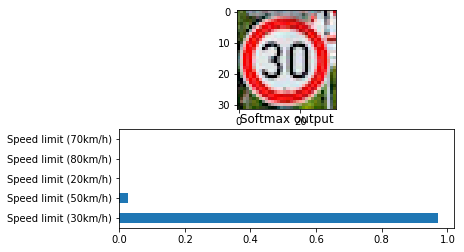

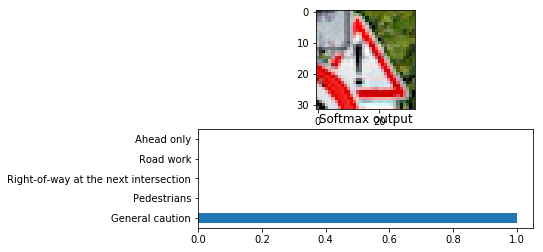

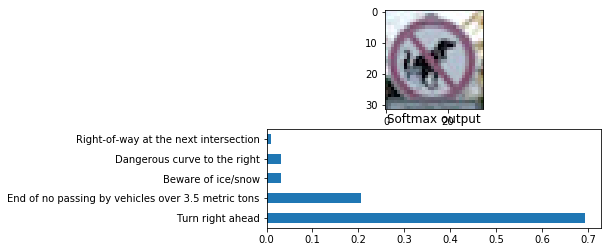

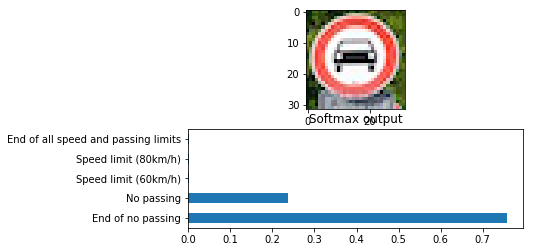

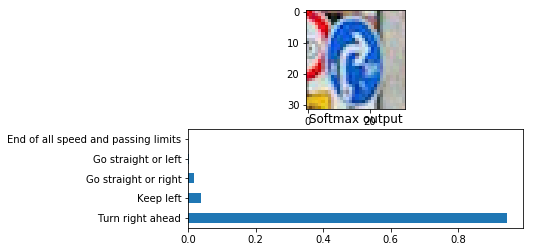

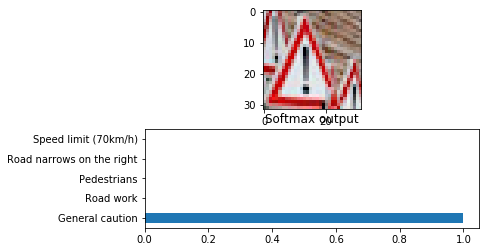

In [2]:
import numpy as np
import csv
import tensorflow as tf
from GTInception import GTInception
import pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

classNames = {}
with open('signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile)
    next(namereader, None)
    for num, name in namereader:
        classNames[int(num)] = name


imgfolder = 'web_images/'
imageNames = {0 : '30kmh.jpg', 1:'danger.jpg',
              2:'dogpoop.jpg', 3:'dontpass.jpg',
              4:'turn.jpg', 5:'danger1.jpg'}


# Set up the tf variables
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
global_step = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


logits, Wout = GTInception(x, keep_prob)
net_op = tf.nn.softmax(logits, dim=-1)
pred_op = tf.nn.top_k(net_op, k = 5, name='Top5Select')


results = {}

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_path='./GTInception')

    for key, imgname in imageNames.items():
        imgfile = imgfolder + imgname
        image = mpimg.imread(imgfile)
        img_exp = np.expand_dims(image, axis=0)
        values, classes = sess.run(pred_op, feed_dict={x: img_exp.astype(dtype='float32'), keep_prob:1.0})
        classes = [classNames[int(c)] for c in np.nditer(classes)]
        results[key] = (values, classes, image)


for key, val in results.items():
    values, classes, image = val[0], val[1], val[2]

    df = pandas.DataFrame.from_items(zip(classes, values.tolist()))
    figure = plt.figure()
    ax = figure.add_subplot(210 + 1 + 0)
    ax.imshow(image.squeeze())
    ax = figure.add_subplot(210 + 1 + 1)
    ax = df.plot(kind='barh', legend=False, ax = ax)
    ax.set_yticklabels(classes, rotation=0)
    plt.title('Softmax output')